In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from math import sqrt
from foursquareAPI import get_poi

In [3]:
df = pd.read_csv("Parkirisca_do_10_05_2022.csv")
df["Zasedenost"] = df["Kapaciteta"] - df["Prosta mesta"]
df['date'] = pd.to_datetime(df["Datum"], unit="s")
df = df.drop(["Datum", "Prosta (narocniki)", "Oddana (narocniki)",
             "Na voljo (narocniki)", "Cakalna vrsta (narocniki)"], axis=1)
df

,Parkirisce,Prosta mesta,Kapaciteta,Zasedenost,date
0,Bezigrad,58,64,6,2022-02-24 19:13:21
1,Center Stozice,142,509,367,2022-02-24 19:13:21
2,Dolenjska cesta (Strelisce),50,67,17,2022-02-24 19:13:21
3,Gosarjeva ulica,16,190,174,2022-02-24 19:13:21
4,Gosarjeva ulica II.,121,115,-6,2022-02-24 19:13:21
...,...,...,...,...,...
292887,SRC Stozice,0,0,0,2022-05-10 06:05:38
292888,Tacen,0,0,0,2022-05-10 06:05:38
292889,Bratislavska,0,0,0,2022-05-10 06:05:38
292890,BS4/ I,63,80,17,2022-05-10 06:05:38


In [4]:
def copy_and_impute(parking):
    # Prepare new data frame, which will be synced (freqeuncy is exactly 10 mins)
    parking_sync = parking.asfreq("10 min")

    # Copy data before hole 1
    hole_start_date1 = pd.to_datetime("2022-03-15 08:25:12", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iterrows()):
        if index > hole_start_date1:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute first hole
    hole_end_date1 = pd.to_datetime("2022-03-23 07:02:59", format='%Y-%m-%d %H:%M:%S')
    num_rows_imputed = 0
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date1:
            continue
        if index_sync >= hole_end_date1:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy data after hole 1, before hole 2
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date1:
            continue
        if index >= hole_start_date2:
            break
        row_sync["Zasedenost"] = row["Zasedenost"]

    # Impute second hole
    hole_end_date2 = pd.to_datetime("2022-04-22 08:11:54", format='%Y-%m-%d %H:%M:%S')
    for index_sync, row_sync in parking_sync.iterrows():
        if index_sync <= hole_start_date2:
            continue
        if index_sync > hole_end_date2:
            break
        # Repeat data from previous week day
        row_sync["Zasedenost"] = parking_sync[parking_sync.index ==
                                              index_sync - pd.to_timedelta(1, unit="W")]["Zasedenost"][0]
        num_rows_imputed += 1

    # Copy the remaning data
    hole_start_date2 = pd.to_datetime("2022-04-07 22:10:55", format='%Y-%m-%d %H:%M:%S')
    for ((index, row), (index_sync, row_sync)) in zip(parking.iterrows(), parking_sync.iloc[num_rows_imputed:].iterrows()):
        if index < hole_end_date2:
            continue
        row_sync["Zasedenost"] = row["Zasedenost"]

    parking_sync = parking_sync["Zasedenost"].fillna(method="bfill")  # Fill remaning spaces with previous values
    parking_sync.dropna(axis=0, inplace=True)  # Remove the somehow remaning NaN rows

    return parking_sync

In [5]:
parkings = {}
for name, group in df.groupby("Parkirisce"):
    name = str(name)
    parking = group

    parking = parking.set_index('date')
    parking = parking.drop(["Parkirisce", "Prosta mesta"], axis=1)

    capacity = 0
    for _, row in parking.iterrows():
        if row["Kapaciteta"] != 0:
            capacity = row["Kapaciteta"]
            break

    raidus = 50
    points_of_interest = get_poi(name, radius=raidus)

    # Filter empty data (10 parkings)
    if (parking["Zasedenost"] == 0).all() or (parking["Zasedenost"] == capacity).all() or points_of_interest is None:
        continue

    parking_sync = pd.DataFrame(copy_and_impute(parking))
    parking_sync["Kapaciteta"] = [capacity for _ in range(len(parking_sync.index))]
    parking_sync["Procent_zasedenosti"] = parking_sync["Zasedenost"] / parking_sync["Kapaciteta"]

    # Add points of interest to the specific column (0: not present, radius-distance: point of interest score) -> POIs are weighted
    restaurant_dist = []
    art_dist = []
    coffee_dist = []
    bar_dist = []
    for distance, poi in points_of_interest:
        if "Restaurant" in poi:
            restaurant_dist.append(distance)
        elif "Art" in poi or "Museum" in poi:
            art_dist.append(distance)
        elif "Coffee" in poi or "Café" in poi or "Cafeteria" in poi:
            coffee_dist.append(distance)
        elif "Bar" in poi:
            bar_dist.append(distance)
    
    restaurant_score = 0 if not restaurant_dist else raidus + 1 - sum(restaurant_dist) / len(restaurant_dist)
    art_score = 0 if not art_dist else raidus + 1 - sum(art_dist) / len(art_dist)
    coffee_score = 0 if not coffee_dist else raidus + 1 - sum(coffee_dist) / len(coffee_dist)
    bar_score = 0 if not bar_dist else raidus + 1 - sum(bar_dist) / len(bar_dist)
    
    parking_sync["Restaurant_score"] = [restaurant_score for _ in range(len(parking_sync.index))]
    parking_sync["Art_score"] = [art_score for _ in range(len(parking_sync.index))]
    parking_sync["Coffee_score"] = [coffee_score for _ in range(len(parking_sync.index))]
    parking_sync["Bar_score"] = [bar_score for _ in range(len(parking_sync.index))]

    parking_sync = parking_sync.astype({"Zasedenost": int, "Kapaciteta": int, "Procent_zasedenosti": float,
                                               "Restaurant_score": float,	"Art_score": float,	"Coffee_score": float,	"Bar_score": float})

    parkings[name] = parking_sync  # Save the synced data frame to dict

print(parkings)

{'BS4/ I':                      Zasedenost  Kapaciteta  Procent_zasedenosti  \
date                                                               
2022-03-04 09:31:53           0          80               0.0000   
2022-03-04 09:41:53           0          80               0.0000   
2022-03-04 09:51:53           0          80               0.0000   
2022-03-04 10:01:53           0          80               0.0000   
2022-03-04 10:11:53           0          80               0.0000   
...                         ...         ...                  ...   
2022-05-10 03:51:53          17          80               0.2125   
2022-05-10 04:01:53          16          80               0.2000   
2022-05-10 04:11:53          15          80               0.1875   
2022-05-10 04:21:53          16          80               0.2000   
2022-05-10 04:31:53          17          80               0.2125   

                     Restaurant_score  Art_score  Coffee_score  Bar_score  
date                        

In [6]:
curr_df = parkings["BS4/ I"][["Zasedenost"]]
curr_df

,Zasedenost
date,
2022-03-04 09:31:53,0
2022-03-04 09:41:53,0
2022-03-04 09:51:53,0
2022-03-04 10:01:53,0
2022-03-04 10:11:53,0
...,...
2022-05-10 03:51:53,17
2022-05-10 04:01:53,16
2022-05-10 04:11:53,15


In [12]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        b = dataset[i + look_back, 0]
        dataY.append(b)
    return np.array(dataX), np.array(dataY)


Epoch 1/5
6442/6442 - 11s - loss: 0.0036 - 11s/epoch - 2ms/step
Epoch 2/5
6442/6442 - 10s - loss: 5.3424e-04 - 10s/epoch - 2ms/step
Epoch 3/5
6442/6442 - 10s - loss: 5.2808e-04 - 10s/epoch - 2ms/step
Epoch 4/5
6442/6442 - 10s - loss: 5.2407e-04 - 10s/epoch - 1ms/step
Epoch 5/5
6442/6442 - 10s - loss: 5.2607e-04 - 10s/epoch - 1ms/step
Train Score: 1.51 RMSE
Test Score: 1.51 RMSE


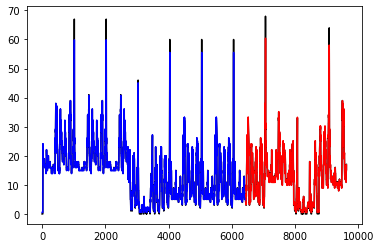

In [24]:
dataset = curr_df.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset), "k-")
plt.plot(trainPredictPlot, "b-")
plt.plot(testPredictPlot, "r-")
plt.show()


Epoch 1/100
92/92 - 1s - loss: 0.0337 - 1s/epoch - 15ms/step
Epoch 2/100
92/92 - 0s - loss: 0.0162 - 135ms/epoch - 1ms/step
Epoch 3/100
92/92 - 0s - loss: 0.0128 - 140ms/epoch - 2ms/step
Epoch 4/100
92/92 - 0s - loss: 0.0120 - 126ms/epoch - 1ms/step
Epoch 5/100
92/92 - 0s - loss: 0.0111 - 117ms/epoch - 1ms/step
Epoch 6/100
92/92 - 0s - loss: 0.0101 - 134ms/epoch - 1ms/step
Epoch 7/100
92/92 - 0s - loss: 0.0091 - 134ms/epoch - 1ms/step
Epoch 8/100
92/92 - 0s - loss: 0.0081 - 130ms/epoch - 1ms/step
Epoch 9/100
92/92 - 0s - loss: 0.0072 - 141ms/epoch - 2ms/step
Epoch 10/100
92/92 - 0s - loss: 0.0064 - 133ms/epoch - 1ms/step
Epoch 11/100
92/92 - 0s - loss: 0.0055 - 122ms/epoch - 1ms/step
Epoch 12/100
92/92 - 0s - loss: 0.0048 - 147ms/epoch - 2ms/step
Epoch 13/100
92/92 - 0s - loss: 0.0041 - 117ms/epoch - 1ms/step
Epoch 14/100
92/92 - 0s - loss: 0.0036 - 142ms/epoch - 2ms/step
Epoch 15/100
92/92 - 0s - loss: 0.0031 - 149ms/epoch - 2ms/step
Epoch 16/100
92/92 - 0s - loss: 0.0027 - 118ms/epoc

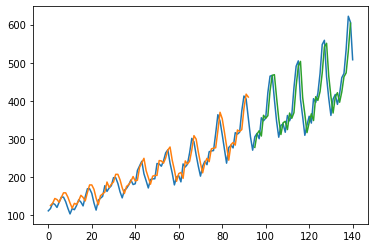

In [1]:
# # https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
# import numpy
# import matplotlib.pyplot as plt
# from pandas import read_csv
# import math
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LSTM
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.metrics import mean_squared_error


# def create_dataset(dataset, look_back=1):
#     dataX, dataY = [], []
#     for i in range(len(dataset)-look_back-1):
#         a = dataset[i:(i+look_back), 0]
#         dataX.append(a)
#         dataY.append(dataset[i + look_back, 0])
#     return numpy.array(dataX), numpy.array(dataY)

# # load the dataset

# dataframe = read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv',
#                      usecols=[1], engine='python', skipfooter=3)


# dataset = dataframe.values
# dataset = dataset.astype('float32')
# # normalize the dataset
# scaler = MinMaxScaler(feature_range=(0, 1))
# dataset = scaler.fit_transform(dataset)
# # split into train and test sets
# train_size = int(len(dataset) * 0.67)
# test_size = len(dataset) - train_size
# train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]
# # reshape into X=t and Y=t+1
# look_back = 1
# trainX, trainY = create_dataset(train, look_back)
# testX, testY = create_dataset(test, look_back)
# # reshape input to be [samples, time steps, features]
# trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
# testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# # create and fit the LSTM network
# model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')
# model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# # make predictions
# trainPredict = model.predict(trainX)
# testPredict = model.predict(testX)
# # invert predictions
# trainPredict = scaler.inverse_transform(trainPredict)
# trainY = scaler.inverse_transform([trainY])
# testPredict = scaler.inverse_transform(testPredict)
# testY = scaler.inverse_transform([testY])
# # calculate root mean squared error
# trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
# print('Train Score: %.2f RMSE' % (trainScore))
# testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
# print('Test Score: %.2f RMSE' % (testScore))
# # shift train predictions for plotting
# trainPredictPlot = numpy.empty_like(dataset)
# trainPredictPlot[:, :] = numpy.nan
# trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# # shift test predictions for plotting
# testPredictPlot = numpy.empty_like(dataset)
# testPredictPlot[:, :] = numpy.nan
# testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# # plot baseline and predictions
# plt.plot(scaler.inverse_transform(dataset))
# plt.plot(trainPredictPlot)
# plt.plot(testPredictPlot)
# plt.show()
